In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

from itertools import chain

from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import regex as re
from collections import namedtuple, defaultdict, Counter, OrderedDict
from IPython.display import display
from joblib import load, dump, Parallel, delayed

import os, string, sys

from gensim.models import word2vec

In [2]:
class RegexFeatures(object):
    PATTERNS = {
        "isInitCapitalWord": re.compile(r'^[A-Z][a-z]+'),
        "isAllCapitalWord": re.compile(r'^[A-Z][A-Z]+$'),
        "isAllSmallCase": re.compile(r'^[a-z]+$'),
        "isWord": re.compile(r'^[a-zA-Z][a-zA-Z]+$'),
        "isAlphaNumeric": re.compile(r'^\p{Alnum}+$'),
        "isSingleCapLetter": re.compile(r'^[A-Z]$'),
        "containsDashes": re.compile(r'.*--.*'),
        "containsDash": re.compile(r'.*\-.*'),
        "singlePunctuation": re.compile(r'^\p{Punct}$'),
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "singleDot": re.compile(r'[.]'),
        "singleComma": re.compile(r'[,]'),
        "singleQuote": re.compile(r'[\']'),
        "isSpecialCharacter": re.compile(r'^[#;:\-/<>\'\"()&]$'),
        "fourDigits": re.compile(r'^\d\d\d\d$'),
        "isDigits": re.compile(r'^\d+$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "containsDigit": re.compile(r'.*\d+.*'),
        "endsWithDot": re.compile(r'\p{Alnum}+\.$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@\p{Alnum}+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print "Initialized RegexFeature"
    @staticmethod
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features
    
    
def classification_report_to_df(report):
    report_list = []
    for i, line in enumerate(report.split("\n")):
        if i == 0:
            report_list.append(["class", "precision", "recall", "f1-score", "support"])
        else:
            line = line.strip()
            if line:
                if line.startswith("avg"):
                    line = line.replace("avg / total", "avg/total")
                line = re.split(r'\s+', line)
                report_list.append(tuple(line))
    return pd.DataFrame(report_list[1:], columns=report_list[0])


DATA_DIR="data/data/"
CLEANED_DIR="data/cleaned/"

Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if test_data:
                    assert len(line) == 1
                    line.append("?")
                if notypes:
                    line[1] = line[1][0]
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences


def load_vocab(filename):
    vocab = set()
    with open(filename) as fp:
        for line in fp:
            line = line.strip()
            vocab.add(line)
    return vocab      

    
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
        
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr)) 
        
        
def plot_cm(y_test, y_pred, labels=[]):
    labels_s = dict((k,i) for i,k in enumerate(labels))
    cm = np.zeros((len(labels), len(labels)))
    for i,j in zip(sum(y_test, []), sum(y_pred, [])):
        i = labels_s[i]
        j = labels_s[j]
        cm[i,j] += 1
    with plt.rc_context(rc={'xtick.labelsize': 12, 'ytick.labelsize': 12,
                       'figure.figsize': (16,14)}):
        sns.heatmap(cm * 100/ cm.sum(axis=1, keepdims=True),
                    #cmap=sns.cubehelix_palette(n_colors=100, rot=-.4, as_cmap=True),
                    cmap="Greys_r",
                    xticklabels=labels,
                    yticklabels=labels)
        plt.ylabel("True labels")
        plt.xlabel("Predicted labels")
    print cm.shape
    return cm


def print_sequences(sequences, predictions, filename, test_data=False):
    with open(filename, "wb+") as fp:
        for seq, pred in zip(sequences, predictions):
            for t, p in zip(seq, pred):
                token, tag = t
                if tag[0] == "U":
                    tag = "B%s" % tag[1:]
                if tag[0] == "E":
                    tag = "I%s" % tag[1:]
                if p[0] == "U":
                    p = "B%s" % p[1:]
                if p[0] == "E":
                    p = "I%s" % p[1:]
                if test_data:
                    line = "\t".join((token, p))
                else:
                    line = "\t".join((token, tag, p))
                print >> fp, line
            print >> fp, ""
    print "Done"

In [3]:
WORD_SPLITTER = re.compile(r'[\p{Punct}\s]+')
class DictionaryFeatures:
    def __init__(self, dictDir):
        self.word2dictionaries = {}
        self.word2hashtagdictionaries = {}
        self.dictionaries = []
        i = 0
        for d in os.listdir(dictDir):
            print >> sys.stderr, "read dict %s"%d
            self.dictionaries.append(d)
            if d == '.svn':
                continue
            for line in open(dictDir + "/" + d):
                word = line.rstrip('\n')
                word = word.strip(' ').lower()
                word_hashtag = "".join(WORD_SPLITTER.split(word))
                if not self.word2dictionaries.has_key(word):
                    self.word2dictionaries[word] = str(i)
                else:   
                    self.word2dictionaries[word] += "\t%s" % i
                if not self.word2hashtagdictionaries.has_key(word_hashtag):
                    self.word2hashtagdictionaries[word_hashtag] = str(i)
                else:
                    self.word2hashtagdictionaries[word_hashtag] += "\t%s" % i
            i += 1
    
    MAX_WINDOW_SIZE=6
    def GetDictFeatures(self, words, i):
        features = []
        for window in range(1,self.MAX_WINDOW_SIZE):
            start=max(i-window+1, 0)
            end = start + window
            phrase = ' '.join(words[start:end]).lower().strip(string.punctuation)
            if self.word2dictionaries.has_key(phrase):
                for j in self.word2dictionaries[phrase].split('\t'):
                    features.append('DICT=%s' % self.dictionaries[int(j)])
                if window > 1:
                    features.append('DICTWIN=%s' % window)
        return list(set(features))
    
    def GetHashtagDictFeatures(self, word):
        features = []
        if len(word) < 2 or word[0] != "#":
            return features
        word = word[1:].lower().strip(string.punctuation)
        if self.word2hashtagdictionaries.has_key(word):
            for j in self.word2hashtagdictionaries[word].split('\t'):
                features.append('DICT_HASHTAG=%s' % self.dictionaries[int(j)])
        return list(set(features))


In [4]:
train_sequences = load_sequences("data/cleaned/train.BIEOU.tsv", sep="\t", notypes=False)
dev_sequences = (load_sequences("data/cleaned/dev.BIEOU.tsv", sep="\t", notypes=False) 
                 + load_sequences("data/cleaned/dev_2015.BIEOU.tsv", sep="\t", notypes=False))

vocab = load_vocab("vocab.no_extras.txt")
print len(vocab)

8023


{'product': 6, 'facility': 5, 'movie': 8, 'company': 3, 'sportsteam': 4, 'musicartist': 7, 'person': 0, 'other': 2, 'geo-loc': 1, 'tvshow': 9}
Counter({'person': 693, 'geo-loc': 439, 'other': 404, 'company': 243, 'sportsteam': 156, 'facility': 151, 'product': 144, 'musicartist': 112, 'movie': 52, 'tvshow': 42})


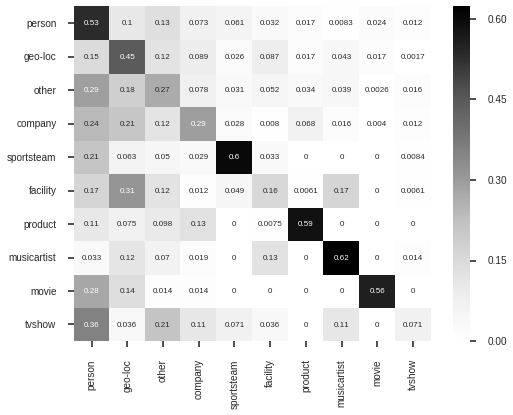

In [5]:
label_co_occurences = [[t[1][2:] for t in seq if t[1][0] in ["B", "U"]] for seq in (train_sequences+dev_sequences)]

cat_types = Counter(t for seq in label_co_occurences for t in seq)
cat_ids = {k[0]: i for i, k in enumerate(cat_types.most_common())}
cat_names = [k[0] for k in cat_types.most_common()]
print cat_ids
print cat_types
co_occur_matrix = np.zeros((len(cat_ids), len(cat_ids)))
for seq in label_co_occurences:
    for i, t in enumerate(seq):
        for j, t1 in enumerate(seq):
            if i != j:
                co_occur_matrix[cat_ids[t], cat_ids[t1]] += 1
for k,i in cat_ids.iteritems():
    co_occur_matrix[cat_ids[k]] /= co_occur_matrix[cat_ids[k]].sum()
    
#print co_occur_matrix
    
with plt.rc_context(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10,
                        'font.size': 8,
                       'figure.figsize': (8,6)}):
    sns.heatmap(co_occur_matrix, xticklabels=cat_names, yticklabels=cat_names, annot=True, cmap="Greys")

['person', 'geo-loc', 'other', 'company', 'facility', 'product', 'musicartist', 'sportsteam', 'movie', 'tvshow']
Training sequences: 2394
Development sequences: 1420


training    1499
dev          937
Name: data, dtype: int64

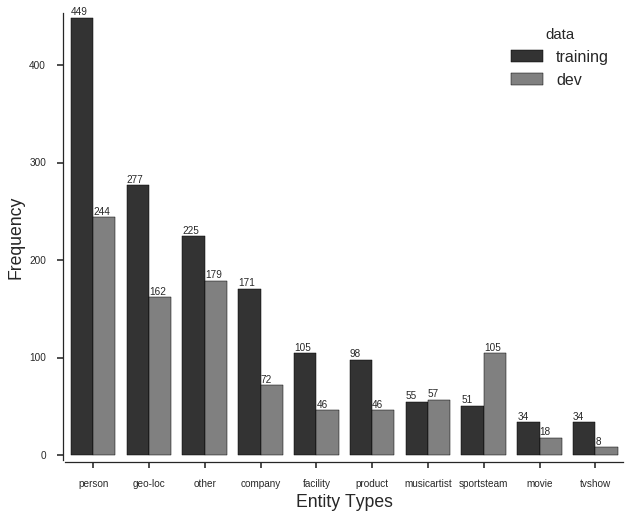

In [6]:
phrase_types_training = [(t[1][2:], "training") for seq in (train_sequences) for t in seq if t[1][0] in ["B", "U"]]
phrase_types_dev = [(t[1][2:], "dev") for seq in (dev_sequences) for t in seq if t[1][0] in ["B", "U"]]
df_t = pd.DataFrame(phrase_types_training+phrase_types_dev, columns=["phrase_type", "data"])
cat_names = [k[0] for k,v in Counter(phrase_types_training).most_common()]
print cat_names
with plt.rc_context(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10,
                        'font.size': 10,
                       'figure.figsize': (10,8)}):
    ax = sns.countplot(x="phrase_type", hue="data", data=df_t, palette=["0.2", "0.5"], order=cat_names)
    plt.xlabel("Entity Types")
    plt.ylabel("Frequency")
    plt.margins(0.01)
    sns.despine(offset=2)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x(), height+3, '%.0f'%(height))
        
print "Training sequences: {}".format(len(train_sequences))
print "Development sequences: {}".format(len(dev_sequences))
df_t.data.value_counts()

In [7]:
train_lens = [len(seq) for seq in train_sequences]
dev_lens = [len(seq) for seq in dev_sequences]
print "Training lengths: {0:.1f} +/- {1:.1f}".format(np.mean(train_lens),
                                                   np.std(train_lens))
print "Development lengths: {0:.1f} +/- {1:.1f}".format(np.mean(dev_lens),
                                                   np.std(dev_lens))

Training lengths: 19.4 +/- 7.6
Development lengths: 16.2 +/- 6.8


In [8]:
train_phrase_counts = [len([t[1][2:] for t in seq if t[1][0] in ["B", "U"]])
                       for seq in (train_sequences)]
dev_phrase_counts = [len([t[1][2:] for t in seq if t[1][0] in ["B", "U"]])
                       for seq in (dev_sequences)]

print "Training phrase counts: {} - {}".format(
    np.min(train_phrase_counts), np.max(train_phrase_counts))
print "Development phrase counts: {} - {}".format(
    np.min(dev_phrase_counts), np.max(dev_phrase_counts))

Training phrase counts: 0 - 6
Development phrase counts: 0 - 9


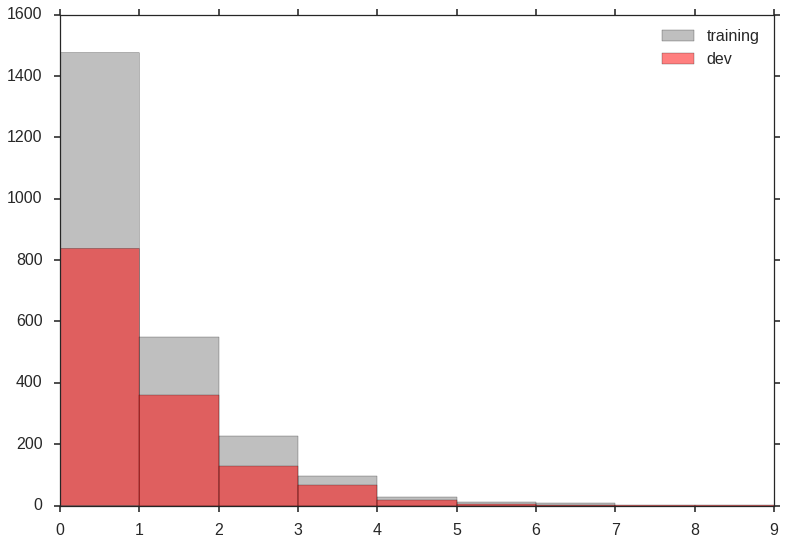

In [9]:
plt.hist(train_phrase_counts, bins=range(10), color="0.5", alpha=0.5, label="training")
plt.hist(dev_phrase_counts, bins=range(10), color="red", alpha=0.5, label="dev")
plt.legend()

In [10]:
train_phrase_counts.index(6)

445

In [11]:
train_sequences[445]

[Tag(token='Yahoo', tag='U-company'),
 Tag(token=':', tag='O'),
 Tag(token='Jackie', tag='U-person'),
 Tag(token='joins', tag='O'),
 Tag(token='Twitter', tag='U-company'),
 Tag(token='50', tag='O'),
 Tag(token='years', tag='O'),
 Tag(token='after', tag='O'),
 Tag(token='JFK', tag='U-person'),
 Tag(token='campaign', tag='O'),
 Tag(token=':', tag='O'),
 Tag(token='Had', tag='O'),
 Tag(token='Twitter', tag='U-company'),
 Tag(token='been', tag='O'),
 Tag(token='an', tag='O'),
 Tag(token='option', tag='O'),
 Tag(token='in', tag='O'),
 Tag(token='1960', tag='O'),
 Tag(token=',', tag='O'),
 Tag(token='a', tag='O'),
 Tag(token='pregnant', tag='O'),
 Tag(token='Jacquelin', tag='U-person'),
 Tag(token='...', tag='O'),
 Tag(token='http://yhoo.it/9VAD4A', tag='O')]

In [19]:
data = """F	MF	+GZ	+WRG	+WCBPT	+WCCC	+WRFTC	+GF	+RSFD	ST	BL
10-types	5.32	34.8	36.66	41.59	41.04	43.3	40.94		36.22	35.1
company	0	30	34.53	33.33	35.2	33.33	32		27.72	26.17
facility	0	12.35	9.62	20.78	18.56	17.91	14.49		30.38	19.15
geo-loc	5.24	47.21	48.06	53.83	54.4	55.93	56.73		49.71	48.36
movie	8	7.41	6.45	8.33	7.69	9.52	23.53		8.33	0
musicartist	0	6.56	8.45	9.09	9.52	12.7	6.45		0	0
other	5.79	18.56	18.69	22.54	20.85	26.63	22.11		24.16	27.74
person	11.37	55.07	58.51	63.39	63.81	64.82	64.96		53.36	50.18
product	2.92	12.66	20	16.67	18.18	15.38	10.75		8.96	11.9
sportsteam	0	12.9	27.94	30.53	29.01	28.13	27.69		12.8	13.11
tvshow	0	0	0	16.67	16.67	16.67	18.18		0	14.29
No-types	13.13	48.31	52.51	56.73	56.41	57.38	53.67		50.53	51.71"""

In [50]:
df_t = pd.DataFrame([[t.strip() for t in line.split("\t")] for line in data.split("\n")[1:]])
#df_t.columns = data.split("\n")[0].split()
df_t.columns

RangeIndex(start=0, stop=11, step=1)

In [51]:
len(data.split("\n")[0].split("\t"))

11

In [52]:
df_t.shape

(12, 11)

In [53]:
df_t.columns = data.split("\n")[0].split("\t")
df_t

,F,MF,+GZ,+WRG,+WCBPT,+WCCC,+WRFTC,+GF,+RSFD,ST,BL
0,10-types,5.32,34.8,36.66,41.59,41.04,43.3,40.94,,36.22,35.1
1,company,0,30,34.53,33.33,35.2,33.33,32,,27.72,26.17
2,facility,0,12.35,9.62,20.78,18.56,17.91,14.49,,30.38,19.15
3,geo-loc,5.24,47.21,48.06,53.83,54.4,55.93,56.73,,49.71,48.36
4,movie,8,7.41,6.45,8.33,7.69,9.52,23.53,,8.33,0
5,musicartist,0,6.56,8.45,9.09,9.52,12.7,6.45,,0,0
6,other,5.79,18.56,18.69,22.54,20.85,26.63,22.11,,24.16,27.74
7,person,11.37,55.07,58.51,63.39,63.81,64.82,64.96,,53.36,50.18
8,product,2.92,12.66,20,16.67,18.18,15.38,10.75,,8.96,11.9
9,sportsteam,0,12.9,27.94,30.53,29.01,28.13,27.69,,12.8,13.11


In [54]:
df_t[df_t["F"] == "10-types"]

,F,MF,+GZ,+WRG,+WCBPT,+WCCC,+WRFTC,+GF,+RSFD,ST,BL
0,10-types,5.32,34.8,36.66,41.59,41.04,43.3,40.94,,36.22,35.1


In [57]:
df_t=df_t.set_index("F")
df_t

,MF,+GZ,+WRG,+WCBPT,+WCCC,+WRFTC,+GF,+RSFD,ST,BL
F,,,,,,,,,,
10-types,5.32,34.8,36.66,41.59,41.04,43.3,40.94,,36.22,35.1
company,0,30,34.53,33.33,35.2,33.33,32,,27.72,26.17
facility,0,12.35,9.62,20.78,18.56,17.91,14.49,,30.38,19.15
geo-loc,5.24,47.21,48.06,53.83,54.4,55.93,56.73,,49.71,48.36
movie,8,7.41,6.45,8.33,7.69,9.52,23.53,,8.33,0
musicartist,0,6.56,8.45,9.09,9.52,12.7,6.45,,0,0
other,5.79,18.56,18.69,22.54,20.85,26.63,22.11,,24.16,27.74
person,11.37,55.07,58.51,63.39,63.81,64.82,64.96,,53.36,50.18
product,2.92,12.66,20,16.67,18.18,15.38,10.75,,8.96,11.9


In [62]:
df_t = df_t.drop("+RSFD", axis=1)
df_t

,MF,+GZ,+WRG,+WCBPT,+WCCC,+WRFTC,+GF,ST,BL
F,,,,,,,,,
10-types,5.32,34.8,36.66,41.59,41.04,43.3,40.94,36.22,35.1
company,0,30,34.53,33.33,35.2,33.33,32,27.72,26.17
facility,0,12.35,9.62,20.78,18.56,17.91,14.49,30.38,19.15
geo-loc,5.24,47.21,48.06,53.83,54.4,55.93,56.73,49.71,48.36
movie,8,7.41,6.45,8.33,7.69,9.52,23.53,8.33,0
musicartist,0,6.56,8.45,9.09,9.52,12.7,6.45,0,0
other,5.79,18.56,18.69,22.54,20.85,26.63,22.11,24.16,27.74
person,11.37,55.07,58.51,63.39,63.81,64.82,64.96,53.36,50.18
product,2.92,12.66,20,16.67,18.18,15.38,10.75,8.96,11.9


In [64]:
df_t = df_t.astype("float")

In [67]:
pd.DataFrame(df_t.ix["10-types"])

,10-types
MF,5.32
+GZ,34.80
+WRG,36.66
+WCBPT,41.59
+WCCC,41.04
+WRFTC,43.30
+GF,40.94
ST,36.22
BL,35.10


In [71]:
df_tt = pd.DataFrame(df_t.ix["10-types"])

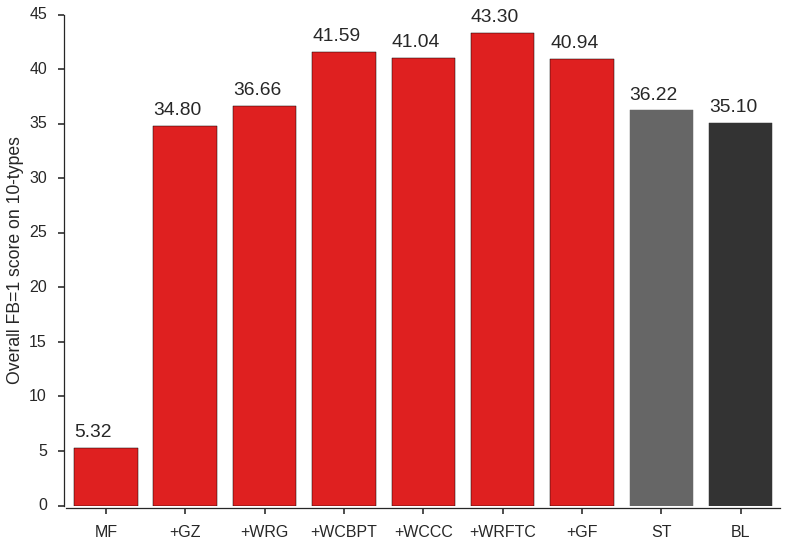

In [102]:
ax = sns.barplot(y="10-types", x=df_tt.index, data=df_tt, color="red")
sns.despine(offset=2)
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x(), height+1, '%.2f'%(height))
        
ax.patches[-2].set_color("0.4")
p.set_color("0.2")
ax.set_ylabel("Overall FB=1 score on 10-types")

        

In [47]:
sns.barplot(data=pd.DataFrame(df_t.ix["10-types", :]), y="10-types")

TypeError: unsupported operand type(s) for /: 'str' and 'int'